In [1]:
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Preparing Data

In [3]:
train_df = pd.read_csv("./data/sign_mnist_train.csv")
test_df = pd.read_csv("./data/sign_mnist_test.csv")

In [4]:
print(sorted(train_df['label'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


Since label '9' is missed, we need to remap labes for dataset

In [6]:
class MNIST_Dataset(Dataset):
    def __init__(self, data):
        label_map = {label: idx for idx, label in enumerate(sorted(data['label'].unique()))}
        self.labels = data['label'].map(label_map).values
        self.images = data.drop('label', axis=1).values.astype('float32') / 255.0

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [7]:
train_dataset = MNIST_Dataset(train_df)
test_dataset = MNIST_Dataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=100)
test_loader = DataLoader(test_dataset, batch_size=100)

# Defining model

In [9]:
train_df['label'].nunique()

24

In [10]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(28*28, 24)  # 24 classes

    def forward(self, x):
        return self.linear(x)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LinearModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Running model

In [13]:
def training_loop():
    total_loss = []
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward 
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        total_loss.append(loss.item())
        
        #Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return sum(total_loss) / len(total_loss)

In [14]:
def testing_loop():
    model.eval()
    correct = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            predicted = torch.argmax(output, dim=1)
            correct += (predicted == labels).sum().item()
    return correct / len(test_loader.dataset)

In [15]:
total_loss_full = []
total_accuracy_full = []

for epoch in range(300):
    total_loss_full.append(training_loop())
    total_accuracy_full.append(testing_loop())

# Visualizing

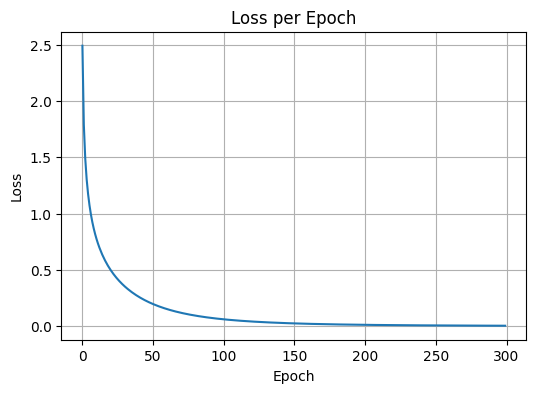

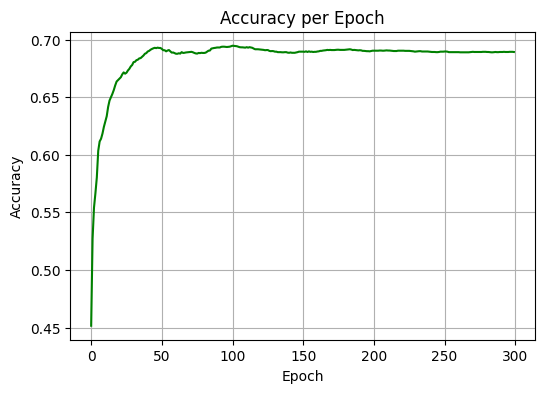

Last accuracy score: 0.6892080312325711


In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(total_loss_full, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.grid(True)

# Accuracy
plt.figure(figsize=(6, 4))
plt.plot(total_accuracy_full, label="Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.grid(True)

plt.show()

print('Last accuracy score:', total_accuracy_full[-1])

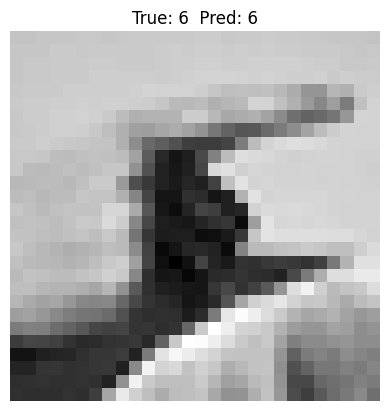

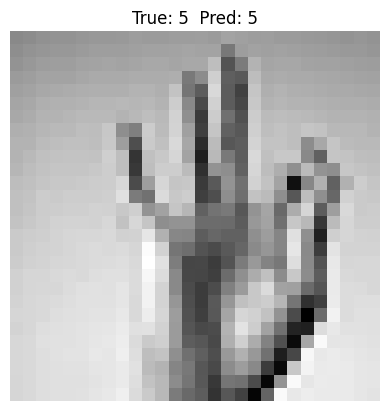

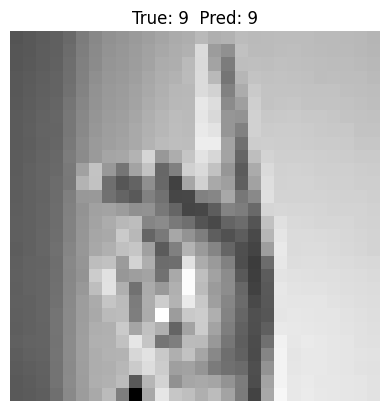

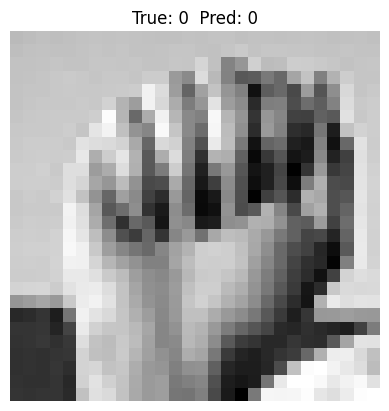

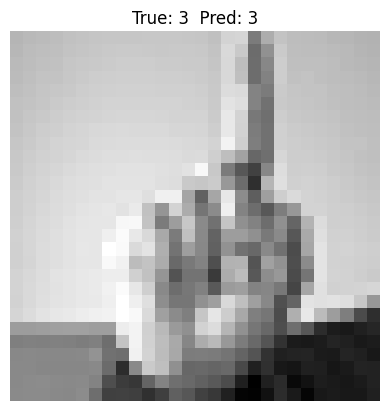

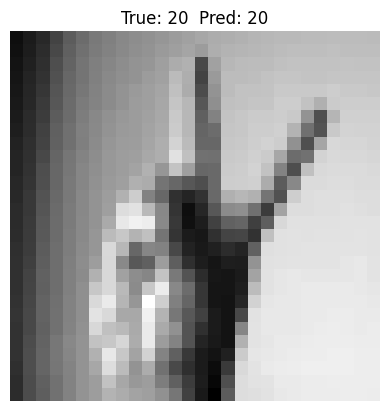

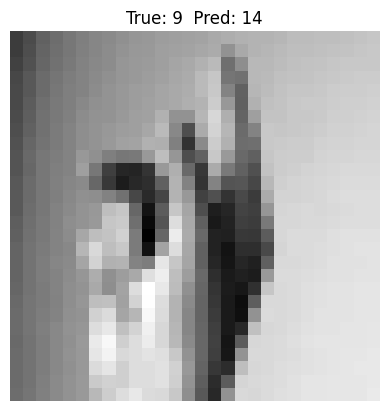

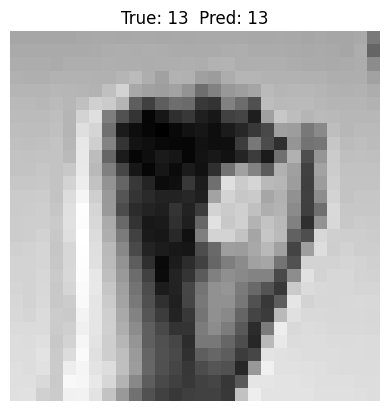

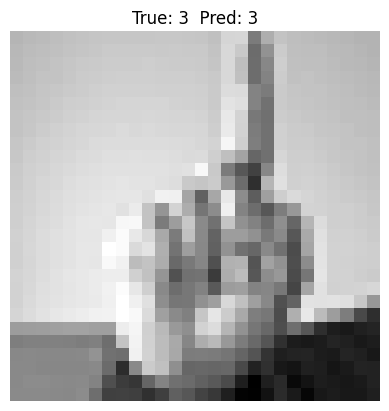

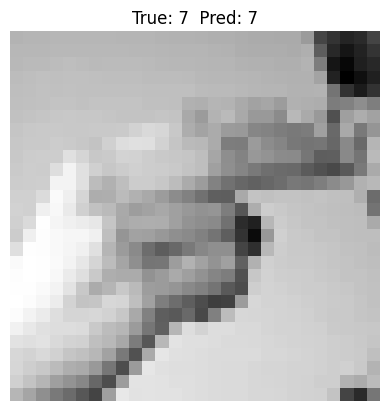

In [18]:
model.eval()

for i in range(10):
    image, true = test_dataset[i]
    input_img = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_img)
        predicted = torch.argmax(output, dim=1).item()
    
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.title(f"True: {true.item()}  Pred: {predicted}")
    plt.axis('off')
    plt.show()
